In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm

# Load the raw TSV files
df_train = pd.read_csv("./data/multimodal_train.tsv", sep="\t")
df_val = pd.read_csv("./data/multimodal_validate.tsv", sep="\t")

# Combine datasets
df_full = pd.concat([df_train, df_val], ignore_index=True)

print(f"Total samples available: {len(df_full)}")
print(f"Columns: {list(df_full.columns)}")
print("\nFirst few rows:")
print(df_full.head())

# Check label distribution
print("\nLabel distribution:")
print(df_full['2_way_label'].value_counts())


Total samples available: 623342
Columns: ['author', 'clean_title', 'created_utc', 'domain', 'hasImage', 'id', 'image_url', 'linked_submission_id', 'num_comments', 'score', 'subreddit', 'title', 'upvote_ratio', '2_way_label', '3_way_label', '6_way_label']

First few rows:
           author                                        clean_title  \
0     Alexithymia  my walgreens offbrand mucinex was engraved wit...   
1        VIDCAs17                this concerned sink with a tiny hat   
2  prometheus1123      hackers leak emails from uae ambassador to us   
3             NaN                           puppy taking in the view   
4       3rikR3ith               i found a face in my sheet music too   

    created_utc         domain  hasImage      id  \
0  1.551641e+09    i.imgur.com      True  awxhir   
1  1.534727e+09      i.redd.it      True  98pbid   
2  1.496511e+09  aljazeera.com      True  6f2cy5   
3  1.471341e+09    i.imgur.com      True  4xypkv   
4  1.525318e+09      i.redd.it     

In [3]:
n_target = 4000

true = df_full.loc[(df_full["2_way_label"] == 1) & ~(df_full["image_url"].isnull())]
fake = df_full.loc[(df_full["2_way_label"] == 0) & ~(df_full["image_url"].isnull())]

# Select the image url only for a valid URL http://i.imgur.com/Iauyw9R.jpg	
fileTypes = ["jpg", "jpeg"]


# Filter 
true_img_url = true.loc[true["image_url"].str.contains("|".join(fileTypes), na=False, case=False)]
fake_img_url = fake.loc[fake["image_url"].str.contains("|".join(fileTypes), na=False, case=False)]


true_sample = true_img_url.sample(n=n_target)
fake_sample = fake_img_url.sample(n=n_target)

df = pd.concat([true_sample, fake_sample], ignore_index=True)


df.shape

# from PIL import Image
# from io import BytesIO
# import requests
# from tqdm import tqdm

# os.makedirs("fakeddit_sample", exist_ok=True)
# df.to_parquet("fakeddit_sample/sample_metadata.parquet")


# os.makedirs("fakeddit_sample/images", exist_ok=True)


# for idx, row in tqdm(df.iterrows(), total=len(df)):
#     url = row['image_url']
#     try:
#         resp = requests.get(url, timeout=5)
#         if resp.status_code != 200:
#             print(f"Failed: {url} -> status {resp.status_code}")
#             continue
#         with open(f"./fakeddit_sample/images/{row['id']}.jpg", "wb") as f:
#             f.write(resp.content)
#     except Exception as e:
#         print(f"Error downloading {url}: {e}")
#         continue

# for path, dirs, filenames in os.walk("./fakeddit_sample/images"):
#     print(filenames)


(8000, 16)

In [4]:
import os
import pandas as pd
idss = []
for path, dirs, filename in os.walk("./fakeddit_sample/images/"):
    for file in filename:
        ids = file.split(".")[0]
        idss.append(ids)



valid_image_df = df_full[df_full["id"].isin(idss)]


true_valid = valid_image_df[valid_image_df["2_way_label"] == 1]
fake_valid = valid_image_df[valid_image_df["2_way_label"] == 0]

downsam_true = true_valid.sample(n=len(fake_valid), random_state=42)

balanced_df = pd.concat([downsam_true, fake_valid])

print(f"Valid image samples: {valid_image_df.shape[0]} samples")



Valid image samples: 5565 samples


In [5]:
# Verify all samples have their corresponding image
image_dir = "./fakeddit_sample/images/"
nonvalid_img = []

for idx, row in balanced_df.iterrows():
    image_path = f"{image_dir}{row['id']}.jpg"
    if not os.path.exists(image_path):
        nonvalid_img.append(row["id"])

print(len(nonvalid_img)) # Meaning every image is usable

0


/tmp/ipykernel_923/4179724710.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


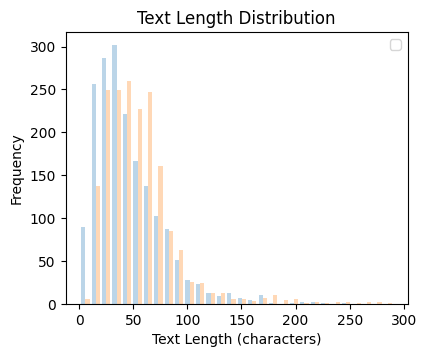

In [6]:
import matplotlib.pyplot as plt
# Exploratory Analysis

plt.figure(figsize=(15, 12))

plt.subplot(3, 3, 1)
fake_text = balanced_df.loc[balanced_df["2_way_label"] == 0, "clean_title"]
true_text = balanced_df.loc[balanced_df["2_way_label"] == 1, "clean_title"]

plt.hist([fake_text.str.len(), true_text.str.len()], bins=30, alpha=0.3)
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.legend()

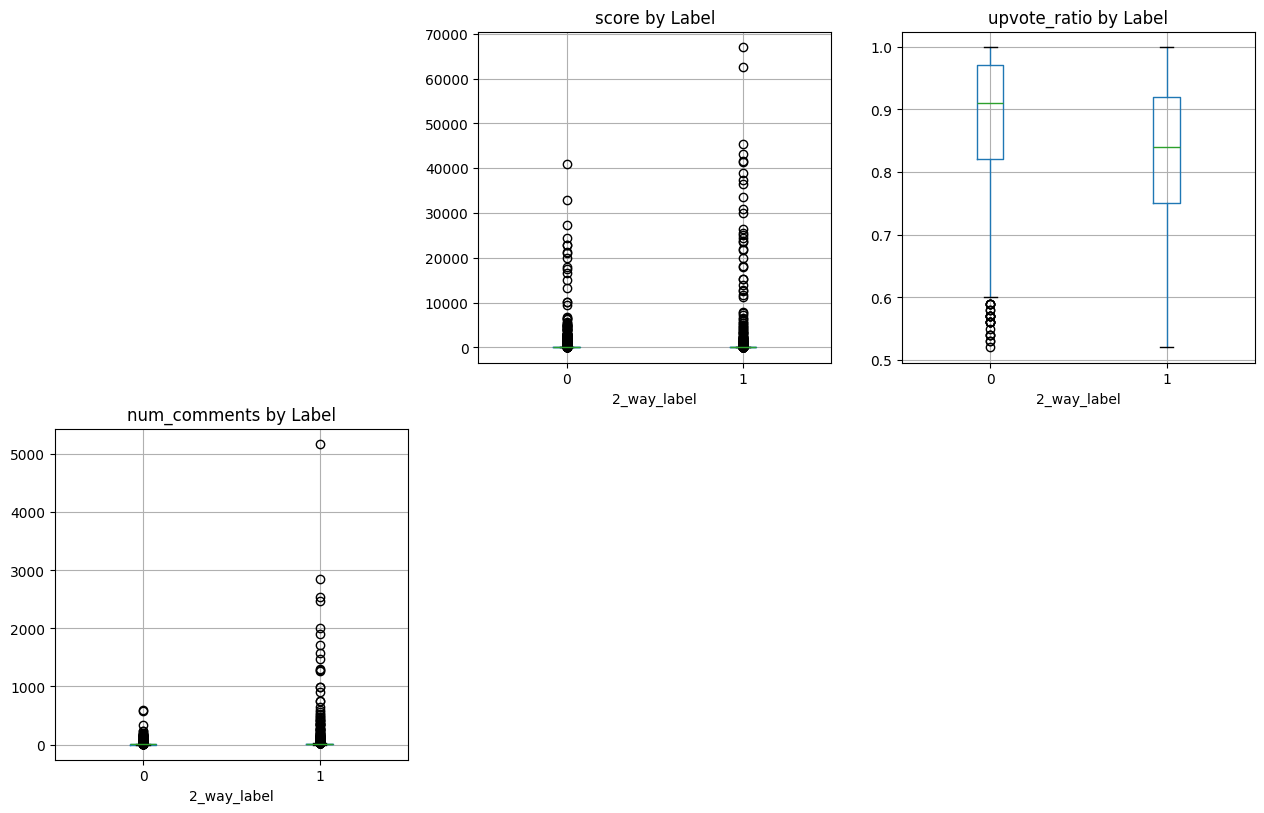

In [7]:
# Metadata analysis
plt.figure(figsize=(15, 15))
metadata_cols = ['score', 'upvote_ratio', 'num_comments']
for i, col in enumerate(metadata_cols):
    if col in balanced_df.columns:
        plt.subplot(3, 3, i+2)
        balanced_df.boxplot(column=col, by='2_way_label', ax=plt.gca())
        plt.title(f'{col} by Label')
        plt.suptitle('')
   

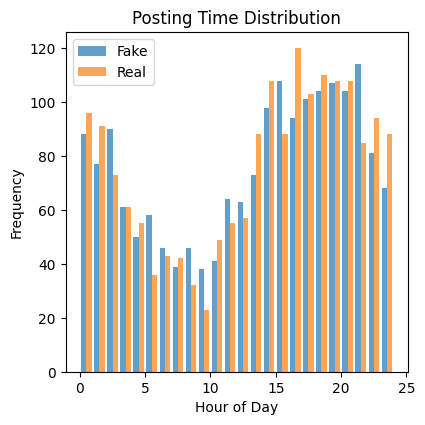

In [8]:
# Time analysis
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 5)
if 'created_utc' in df.columns:
    balanced_df['created_date'] = pd.to_datetime(balanced_df['created_utc'], unit='s')
    balanced_df['hour'] = balanced_df['created_date'].dt.hour
    
    fake_hours = balanced_df[balanced_df['2_way_label'] == 0]['hour']
    real_hours = balanced_df[balanced_df['2_way_label'] == 1]['hour']
    
    bins = range(25)
    plt.hist([fake_hours, real_hours], bins=bins, alpha=0.7, label=['Fake', 'Real'])
    plt.xlabel('Hour of Day')
    plt.ylabel('Frequency')
    plt.title('Posting Time Distribution')
    plt.legend()

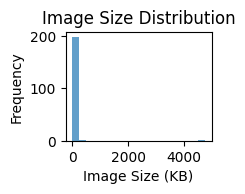

In [9]:
# Image size analysis
plt.subplot(3, 3, 6)
image_sizes = []
sample_ids = balanced_df['id'].sample(min(200, len(df))).tolist()

for sample_id in sample_ids:
    img_path = f"{image_dir}{sample_id}.jpg"
    if os.path.exists(img_path):
        img_size = os.path.getsize(img_path) / 1024  # KB
        image_sizes.append(img_size)

if image_sizes:
    plt.hist(image_sizes, bins=20, alpha=0.7)
    plt.xlabel('Image Size (KB)')
    plt.ylabel('Frequency')
    plt.title('Image Size Distribution')


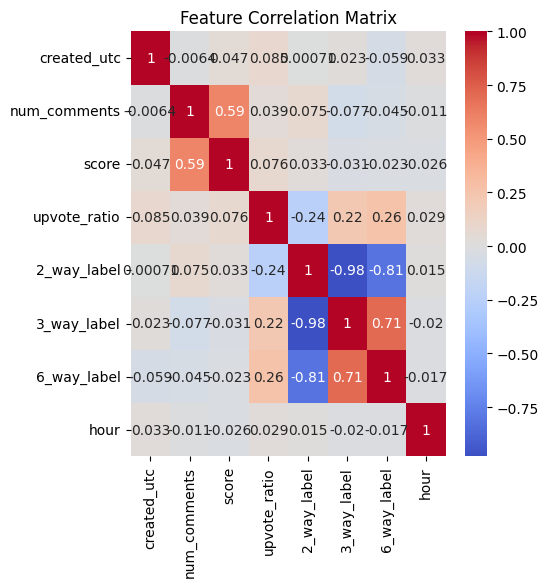

In [10]:
import seaborn as sns
# Correlation matrix
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 9)

numeric_cols = balanced_df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    correlation_matrix = balanced_df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer, CLIPVisionModel, CLIPProcessor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tqdm import tqdm
import pickle

In [12]:
# Try different text encoders in your extractor:
text_models_to_try = [
    "sentence-transformers/all-MiniLM-L12-v2",  # Larger than L6
    "sentence-transformers/all-mpnet-base-v2",  # Often performs better
    "microsoft/DialoGPT-medium",  # Better for conversational text
]

# Try different image encoders:
image_models_to_try = [
    "openai/clip-vit-base-patch16",   # Current
    "openai/clip-vit-large-patch14",  # Larger CLIP
    "facebook/deit-base-patch16-224", # DeiT vision transformer
]

In [13]:
class MultimodalEmbeddingExtractor:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Text embedding extractor (intfloat/e5-large-v2)
        print("Loading intfloat/e5-large-v2 text encoder...")
        self.text_tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-large-v2")
        self.text_model = AutoModel.from_pretrained("intfloat/e5-large-v2")
        self.text_model.to(self.device)
        
        # Image embedding extractor (CLIP ViT-Large-Patch14)
        print("Loading CLIP ViT-Large image encoder...")
        self.image_model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14")
        self.image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
        self.image_model.to(self.device)
        
        # Freeze all parameters - NO TRAINING on these models
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.image_model.parameters():
            param.requires_grad = False
            
        self.text_model.eval()
        self.image_model.eval()
        
        print("✅ E5-Large-v2 and CLIP embedding extractors initialized and frozen!")
        print(f"   Text embedding dim: 1024")
        print(f"   Image embedding dim: 1024") 
        print(f"   Both models on device: {self.device}")
    
    def average_pool(self, last_hidden_states, attention_mask):
        """Average pooling for E5 embeddings"""
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
    
    def extract_text_embeddings(self, texts, batch_size=32):
        """Extract text embeddings using E5-Large-v2"""
        all_embeddings = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting E5 text embeddings"):
            batch_texts = texts[i:i+batch_size]
            
            # Add E5 prefix and handle empty texts
            processed_texts = []
            for text in batch_texts:
                if pd.isna(text) or text is None or str(text).strip() == "":
                    processed_texts.append("query: [NO TEXT]")
                else:
                    processed_texts.append(f"query: {str(text)}")
            
            # Tokenize
            batch_dict = self.text_tokenizer(
                processed_texts,
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors='pt'
            ).to(self.device)
            
            # Extract embeddings
            with torch.no_grad():
                outputs = self.text_model(**batch_dict)
                embeddings = self.average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
                # Normalize embeddings (E5 best practice)
                embeddings = F.normalize(embeddings, p=2, dim=1)
                all_embeddings.append(embeddings.cpu())
            
            # Memory cleanup
            if i % 20 == 0:
                torch.cuda.empty_cache()
        
        return torch.cat(all_embeddings, dim=0).numpy()
    
    def extract_image_embeddings(self, image_paths, batch_size=16):
        """Extract image embeddings with robust handling of corrupted images"""
        all_embeddings = []
        corrupted_count = 0
        
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting CLIP image embeddings"):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []
            
            # Robust image loading
            for img_path in batch_paths:
                try:
                    if os.path.exists(img_path):
                        image = Image.open(img_path)
                        image.verify()  # Check if image is valid
                        image = Image.open(img_path).convert('RGB')  # Reopen after verify
                        batch_images.append(image)
                    else:
                        # Missing image
                        batch_images.append(Image.new('RGB', (224, 224), color='black'))
                        print(f"Warning: Missing image {img_path}")
                except Exception as e:
                    # Corrupted image
                    batch_images.append(Image.new('RGB', (224, 224), color='black'))
                    corrupted_count += 1
                    # Only print first few to avoid spam
                    if corrupted_count <= 5:
                        print(f"Warning: Corrupted image {img_path}: {e}")
            
            # Process batch normally
            try:
                inputs = self.image_processor(images=batch_images, return_tensors="pt")
                pixel_values = inputs['pixel_values'].to(self.device)
                
                with torch.no_grad():
                    outputs = self.image_model(pixel_values=pixel_values)
                    embeddings = outputs.pooler_output
                    all_embeddings.append(embeddings.cpu())
            except Exception as e:
                print(f"Error processing image batch {i}: {e}")
                # Create zero embeddings as fallback
                fallback_embeddings = torch.zeros((len(batch_images), 1024))
                all_embeddings.append(fallback_embeddings)
        
        print(f"✅ Processed {len(image_paths)} images ({corrupted_count} corrupted)")
        return torch.cat(all_embeddings, dim=0).numpy()

    def extract_metadata_features(self, df):
        """Extract robust metadata features with proper regex escaping"""
        features = []
        feature_names = []
        
        # 1. BASIC NUMERICAL FEATURES
        features.append(df['score'].fillna(0).values.astype(float))
        feature_names.append('score')
        
        features.append(df['upvote_ratio'].fillna(0.5).values.astype(float))
        feature_names.append('upvote_ratio')
        
        features.append(df['num_comments'].fillna(0).values.astype(float))
        feature_names.append('num_comments')
        
        # 2. DERIVED ENGAGEMENT FEATURES
        engagement_rate = df['score'] / (df['num_comments'] + 1)
        features.append(engagement_rate.fillna(0).values.astype(float))
        feature_names.append('engagement_rate')
        
        controversy = np.abs(df['upvote_ratio'].fillna(0.5) - 0.5)
        features.append(controversy.values.astype(float))
        feature_names.append('controversy_score')
        
        # 3. TEXT-BASED METADATA FEATURES (with proper escaping)
        if 'clean_title' in df.columns:
            # Text length features
            text_lengths = df['clean_title'].fillna('').str.len()
            features.append(text_lengths.values.astype(float))
            feature_names.append('text_length')
            
            word_counts = df['clean_title'].fillna('').str.split().str.len()
            features.append(word_counts.fillna(0).values.astype(float))
            feature_names.append('word_count')
            
            # Punctuation counts (PROPERLY ESCAPED)
            exclamation_count = df['clean_title'].fillna('').str.count('!')  # No escaping needed
            features.append(exclamation_count.values.astype(float))
            feature_names.append('exclamation_count')
            
            question_count = df['clean_title'].fillna('').str.count(r'\?')  # ESCAPED!
            features.append(question_count.values.astype(float))
            feature_names.append('question_count')
            
            # Capital letter ratio
            def cap_ratio(text):
                if pd.isna(text) or len(text) == 0:
                    return 0
                return sum(1 for c in text if c.isupper()) / len(text)
            
            caps_ratios = df['clean_title'].apply(cap_ratio)
            features.append(caps_ratios.values.astype(float))
            feature_names.append('caps_ratio')
        
        # 4. ENHANCED TEMPORAL FEATURES (cyclical encoding)
        if 'created_utc' in df.columns:
            dt = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
            
            # Cyclical time encoding
            hours = dt.dt.hour.fillna(12)
            hour_sin = np.sin(2 * np.pi * hours / 24)
            hour_cos = np.cos(2 * np.pi * hours / 24)
            features.extend([hour_sin.values, hour_cos.values])
            feature_names.extend(['hour_sin', 'hour_cos'])
            
            days = dt.dt.dayofweek.fillna(3)
            day_sin = np.sin(2 * np.pi * days / 7)
            day_cos = np.cos(2 * np.pi * days / 7)
            features.extend([day_sin.values, day_cos.values])
            feature_names.extend(['day_sin', 'day_cos'])
        
            months = dt.dt.month.fillna(6)
            month_sin = np.sin(2 * np.pi * (months - 1) / 12)
            month_cos = np.cos(2 * np.pi * (months - 1) / 12)
            features.extend([month_sin.values, month_cos.values])
            feature_names.extend(['month_sin', 'month_cos'])
            
            # Weekend and peak hour indicators
            is_weekend = (dt.dt.dayofweek >= 5).astype(float)
            features.append(is_weekend.fillna(0).values)
            feature_names.append('is_weekend')
            
            is_peak_hour = ((hours >= 18) & (hours <= 21)).astype(float)
            features.append(is_peak_hour.values)
            feature_names.append('is_peak_hour')
        
        # Stack and scale features
        metadata_matrix = np.column_stack(features)
        scaler = StandardScaler()
        scaled_metadata = scaler.fit_transform(metadata_matrix)
        
        print(f"✅ Enhanced metadata features: {scaled_metadata.shape[1]} features")
        print(f"   Feature names: {feature_names}")
        
        return scaled_metadata, scaler

# Usage
extractor = MultimodalEmbeddingExtractor()



Using device: cuda
Loading intfloat/e5-large-v2 text encoder...


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Loading CLIP ViT-Large image encoder...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

✅ E5-Large-v2 and CLIP embedding extractors initialized and frozen!
   Text embedding dim: 1024
   Image embedding dim: 1024
   Both models on device: cuda


In [14]:
def extract_all_embeddings_robust(df, extractor, image_dir):
    """Extract embeddings from ALL samples with robust error handling"""
    
    print(f"Processing ALL {len(df)} samples")
    
    # Process ALL texts (handle empty ones gracefully)
    texts = []
    for text in df['clean_title']:
        if pd.isna(text) or str(text).strip() == "":
            texts.append("No title available")  # Meaningful placeholder
        else:
            texts.append(str(text))
    
    text_embeddings = extractor.extract_text_embeddings(texts, batch_size=32)
    print(f"Text embeddings: {text_embeddings.shape}")
    
    # Process ALL images (create fallbacks for missing/corrupted ones)
    image_paths = [f"{image_dir}{row['id']}.jpg" for _, row in df.iterrows()]
    image_embeddings = extractor.extract_image_embeddings(image_paths, batch_size=16)
    print(f"Image embeddings: {image_embeddings.shape}")
    
    # Process ALL metadata
    metadata_features, metadata_scaler = extractor.extract_metadata_features(df)
    print(f"Metadata features: {metadata_features.shape}")
    
    labels = df['2_way_label'].values
    
    return {
        'text_embeddings': text_embeddings,
        'image_embeddings': image_embeddings,
        'metadata_features': metadata_features,
        'labels': labels,
        'valid_df': df,
        'metadata_scaler': metadata_scaler
    }

# Extract embeddings with clean progress bars only
embeddings_data = extract_all_embeddings_robust(balanced_df, extractor, "./fakeddit_sample/images/")
# Save silently
with open('./embeddings/multimodal_embeddings2.pkl', 'wb') as f:
    pickle.dump(embeddings_data, f)

Processing ALL 3626 samples


Extracting E5 text embeddings: 100%|██████████| 114/114 [00:05<00:00, 20.10it/s]


Text embeddings: (3626, 1024)


Extracting CLIP image embeddings:  65%|██████▍   | 147/227 [00:57<00:25,  3.09it/s]

Extracting CLIP image embeddings:  71%|███████   | 161/227 [01:01<00:20,  3.28it/s]

Extracting CLIP image embeddings:  75%|███████▍  | 170/227 [01:04<00:16,  3.36it/s]

Extracting CLIP image embeddings: 100%|██████████| 227/227 [01:21<00:00,  2.77it/s]


✅ Processed 3626 images (3 corrupted)
Image embeddings: (3626, 1024)
✅ Enhanced metadata features: 18 features
   Feature names: ['score', 'upvote_ratio', 'num_comments', 'engagement_rate', 'controversy_score', 'text_length', 'word_count', 'exclamation_count', 'question_count', 'caps_ratio', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_peak_hour']
Metadata features: (3626, 18)


In [15]:
def create_embedding_splits(embeddings_data, test_size=0.2, val_size=0.2):
    """Create train/val/test splits from embeddings"""
    text_emb = embeddings_data['text_embeddings']
    image_emb = embeddings_data['image_embeddings']
    metadata = embeddings_data['metadata_features']
    labels = embeddings_data['labels']
    
    # First split: separate test set
    indices = np.arange(len(labels))
    train_val_idx, test_idx = train_test_split(
        indices, test_size=test_size, random_state=42, stratify=labels
    )
    
    # Second split: separate train and validation
    train_labels = labels[train_val_idx]
    train_idx, val_idx = train_test_split(
        train_val_idx, test_size=val_size, random_state=42, stratify=train_labels
    )
    
    # Create splits
    splits = {
        'train': {
            'text_emb': text_emb[train_idx],
            'image_emb': image_emb[train_idx],
            'metadata': metadata[train_idx],
            'labels': labels[train_idx]
        },
        'val': {
            'text_emb': text_emb[val_idx],
            'image_emb': image_emb[val_idx],
            'metadata': metadata[val_idx],
            'labels': labels[val_idx]
        },
        'test': {
            'text_emb': text_emb[test_idx],
            'image_emb': image_emb[test_idx],
            'metadata': metadata[test_idx],
            'labels': labels[test_idx]
        }
    }
    
    print(f"Train samples: {len(splits['train']['labels'])}")
    print(f"Val samples: {len(splits['val']['labels'])}")
    print(f"Test samples: {len(splits['test']['labels'])}")
    
    return splits

# Create splits
data_splits = create_embedding_splits(embeddings_data)


Train samples: 2320
Val samples: 580
Test samples: 726


In [16]:
class MistralMultimodalMLP(nn.Module):
    def __init__(self, text_dim=1024, image_dim=1024, metadata_dim=18):  
        super().__init__()
        
        proj_dim = 512  # Common projection dimension
        
        
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, proj_dim),  # 4096 -> 512
            nn.LayerNorm(proj_dim),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
        # CLIP image projection (768 -> 512)
        self.image_proj = nn.Sequential(
            nn.Linear(image_dim, proj_dim),  # 768 -> 512
            nn.LayerNorm(proj_dim),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
        # Metadata projection (6 -> 512)
        self.metadata_proj = nn.Sequential(
            nn.Linear(metadata_dim, 128),
            nn.ReLU(),
            nn.Linear(128, proj_dim)  # 6 -> 128 -> 512
        )
        
        # Fusion classifier (concatenated: 512 + 512 + 512 = 1536)
        self.fusion = nn.Sequential(
            nn.Linear(proj_dim * 3, 1024),  # 1536 -> 1024
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2)  # Binary classification
        )
    
    def forward(self, text_emb, image_emb, metadata):
        # Project all modalities to common dimension
        text_feat = self.text_proj(text_emb)      # 4096 -> 512
        image_feat = self.image_proj(image_emb)   # 768 -> 512  
        metadata_feat = self.metadata_proj(metadata)  # 6 -> 512
        
        # Concatenate and classify
        fused = torch.cat([text_feat, image_feat, metadata_feat], dim=1)  # -> 1536
        return self.fusion(fused)  # -> 2

        

class AttentionMultimodalMLP(nn.Module):
    def __init__(self, text_dim=1024, image_dim=1024, metadata_dim=18):
        super().__init__()
        
        proj_dim = 512
        
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, proj_dim),
            nn.LayerNorm(proj_dim),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
        self.image_proj = nn.Sequential(
            nn.Linear(image_dim, proj_dim),
            nn.LayerNorm(proj_dim),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
        self.metadata_proj = nn.Sequential(
            nn.Linear(metadata_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, proj_dim)
        )
        
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=proj_dim, num_heads=8, dropout=0.1, batch_first=True
        )
        
        # Option 1: Matching gate size
        self.gate = nn.Sequential(
            nn.Linear(proj_dim * 3, proj_dim * 3),  # 1536 → 1536
            nn.Sigmoid()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1536, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2)
        )
        
        print(f"Model parameters: {sum(p.numel() for p in self.parameters()):,}")
    
    def forward(self, text_emb, image_emb, metadata):
        # Project to common space
        text_feat = self.text_proj(text_emb).unsqueeze(1)
        image_feat = self.image_proj(image_emb).unsqueeze(1)
        meta_feat = self.metadata_proj(metadata).unsqueeze(1)
        
        # Stack for attention
        features = torch.cat([text_feat, image_feat, meta_feat], dim=1)
        
        # Cross-modal attention
        attended, _ = self.cross_attention(features, features, features)
        
        # Flatten and apply gating
        fused = attended.flatten(1)  # [batch, 1536]
        gate_weights = self.gate(fused)  # [batch, 1536] ✅
        
        return self.classifier(fused * gate_weights)  # Now works! ✅



In [17]:
class EmbeddingDataset(Dataset):
    def __init__(self, text_emb, image_emb, metadata, labels):
        self.text_emb = torch.FloatTensor(text_emb)
        self.image_emb = torch.FloatTensor(image_emb)
        self.metadata = torch.FloatTensor(metadata)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'text_emb': self.text_emb[idx],
            'image_emb': self.image_emb[idx],
            'metadata': self.metadata[idx],
            'label': self.labels[idx]
        }

# Create datasets
train_dataset = EmbeddingDataset(**data_splits['train'])
val_dataset = EmbeddingDataset(**data_splits['val'])
test_dataset = EmbeddingDataset(**data_splits['test'])

# Create dataloaders
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")



Training batches: 73
Validation batches: 19


In [18]:
# Initialize model with correct dimensions
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionMultimodalMLP(
    text_dim=1024,  
    image_dim=1024,  
    metadata_dim=18,
).to(device)
# Training configuration
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc="Training"):
        text_emb = batch['text_emb'].to(device)
        image_emb = batch['image_emb'].to(device)
        metadata = batch['metadata'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        logits = model(text_emb, image_emb, metadata)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(train_loader), correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            text_emb = batch['text_emb'].to(device)
            image_emb = batch['image_emb'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(text_emb, image_emb, metadata)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(val_loader), correct / total

# Training loop
num_epochs = 50
best_val_acc = 0
patience = 5
patience_counter = 0

print("Starting MLP Training!")
print("=" * 50)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Step scheduler
    scheduler.step()
    
    print(f"Epoch {epoch+1:2d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './models/best_model2.pth')
        print(f"🎉 New best model saved! Val Acc: {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")


Model parameters: 6,702,338
Model parameters: 6,702,338
Starting MLP Training!


Validating: 100%|██████████| 19/19 [00:00<00:00, 314.82it/s]


Epoch  1: Train Loss=0.5789, Train Acc=0.6897, Val Loss=0.4531, Val Acc=0.7741
🎉 New best model saved! Val Acc: 0.7741


Validating: 100%|██████████| 19/19 [00:00<00:00, 395.79it/s]


Epoch  2: Train Loss=0.3556, Train Acc=0.8478, Val Loss=0.4119, Val Acc=0.7983
🎉 New best model saved! Val Acc: 0.7983


Validating: 100%|██████████| 19/19 [00:00<00:00, 375.16it/s]


Epoch  3: Train Loss=0.2513, Train Acc=0.8953, Val Loss=0.4353, Val Acc=0.8172
🎉 New best model saved! Val Acc: 0.8172


Validating: 100%|██████████| 19/19 [00:00<00:00, 409.70it/s]


Epoch  4: Train Loss=0.1571, Train Acc=0.9405, Val Loss=0.5532, Val Acc=0.7914


Validating: 100%|██████████| 19/19 [00:00<00:00, 342.79it/s]


Epoch  5: Train Loss=0.1363, Train Acc=0.9453, Val Loss=0.6740, Val Acc=0.7845


Validating: 100%|██████████| 19/19 [00:00<00:00, 371.58it/s]


Epoch  6: Train Loss=0.0878, Train Acc=0.9681, Val Loss=0.6388, Val Acc=0.8224
🎉 New best model saved! Val Acc: 0.8224


Validating: 100%|██████████| 19/19 [00:00<00:00, 368.16it/s]


Epoch  7: Train Loss=0.0383, Train Acc=0.9819, Val Loss=0.8225, Val Acc=0.7948


Validating: 100%|██████████| 19/19 [00:00<00:00, 292.88it/s]


Epoch  8: Train Loss=0.0359, Train Acc=0.9875, Val Loss=0.8967, Val Acc=0.8034


Validating: 100%|██████████| 19/19 [00:00<00:00, 410.61it/s]


Epoch  9: Train Loss=0.0468, Train Acc=0.9806, Val Loss=0.6396, Val Acc=0.7983


Validating: 100%|██████████| 19/19 [00:00<00:00, 293.71it/s]


Epoch 10: Train Loss=0.0372, Train Acc=0.9858, Val Loss=1.0119, Val Acc=0.7948


Validating: 100%|██████████| 19/19 [00:00<00:00, 319.61it/s]

Epoch 11: Train Loss=0.0290, Train Acc=0.9897, Val Loss=0.8522, Val Acc=0.8121
Early stopping triggered!
Training completed! Best validation accuracy: 0.8224


In [19]:
# Load best model and evaluate
model.load_state_dict(torch.load('./models/best_model2.pth'))
model.eval()

def evaluate_model(model, test_loader, device):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            text_emb = batch['text_emb'].to(device)
            image_emb = batch['image_emb'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(text_emb, image_emb, metadata)
            _, predicted = torch.max(logits, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Final evaluation
predictions, labels = evaluate_model(model, test_loader, device)

# Print results
print("\n" + "="*50)
print("FINAL EVALUATION RESULTS")
print("="*50)
print(classification_report(labels, predictions, target_names=['Real News', 'Fake News']))

# Confusion matrix
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels, predictions)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")



Testing: 100%|██████████| 23/23 [00:00<00:00, 362.00it/s]


FINAL EVALUATION RESULTS
              precision    recall  f1-score   support

   Real News       0.85      0.77      0.81       363
   Fake News       0.79      0.87      0.83       363

    accuracy                           0.82       726
   macro avg       0.82      0.82      0.82       726
weighted avg       0.82      0.82      0.82       726


Final Test Accuracy: 0.8209


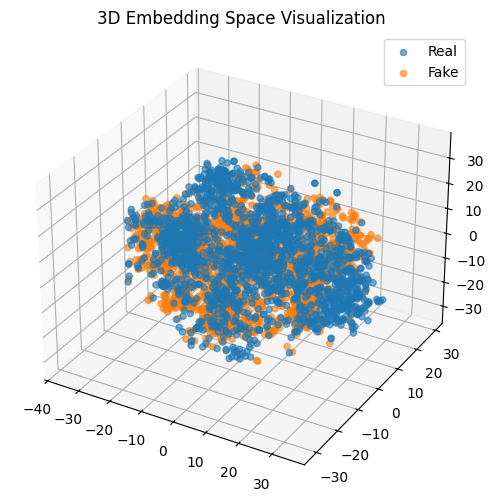

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_embeddings_3d(embeddings_data):
    # Combine all embeddings
    combined_emb = np.concatenate([
        embeddings_data['text_embeddings'],
        embeddings_data['image_embeddings'],
        embeddings_data['metadata_features']
    ], axis=1)
    
    # Reduce to 3D
    tsne = TSNE(n_components=3, random_state=42)
    emb_3d = tsne.fit_transform(combined_emb)
    
    # Plot in 3D
    labels = embeddings_data['labels']
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(emb_3d[labels==0, 0], emb_3d[labels==0, 1], emb_3d[labels==0, 2],
               label='Real', alpha=0.6)
    ax.scatter(emb_3d[labels==1, 0], emb_3d[labels==1, 1], emb_3d[labels==1, 2],
               label='Fake', alpha=0.6)
    
    ax.set_title('3D Embedding Space Visualization')
    ax.legend()
    plt.show()

# Call it
visualize_embeddings_3d(embeddings_data)


In [21]:
# Calculate comprehensive metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


def get_predictions_and_probabilities(model, data_loader, device):
    """Get predictions and probabilities from PyTorch model"""
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            text_emb = batch['text_emb'].to(device)
            image_emb = batch['image_emb'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device)
            
            # Get logits
            logits = model(text_emb, image_emb, metadata)
            
            # Convert to probabilities
            probabilities = F.softmax(logits, dim=1)
            
            # Get predictions
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.append(predictions.cpu().numpy())
            all_probabilities.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    return (np.concatenate(all_predictions), 
            np.concatenate(all_probabilities), 
            np.concatenate(all_labels))

# Usage
y_pred, y_pred_proba, y_true = get_predictions_and_probabilities(model, test_loader, device)

print("Detailed Classification Report:")
print(classification_report(y_true, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred_proba[:, 1]):.4f}")

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       363
           1       0.79      0.87      0.83       363

    accuracy                           0.82       726
   macro avg       0.82      0.82      0.82       726
weighted avg       0.82      0.82      0.82       726

ROC-AUC Score: 0.9009


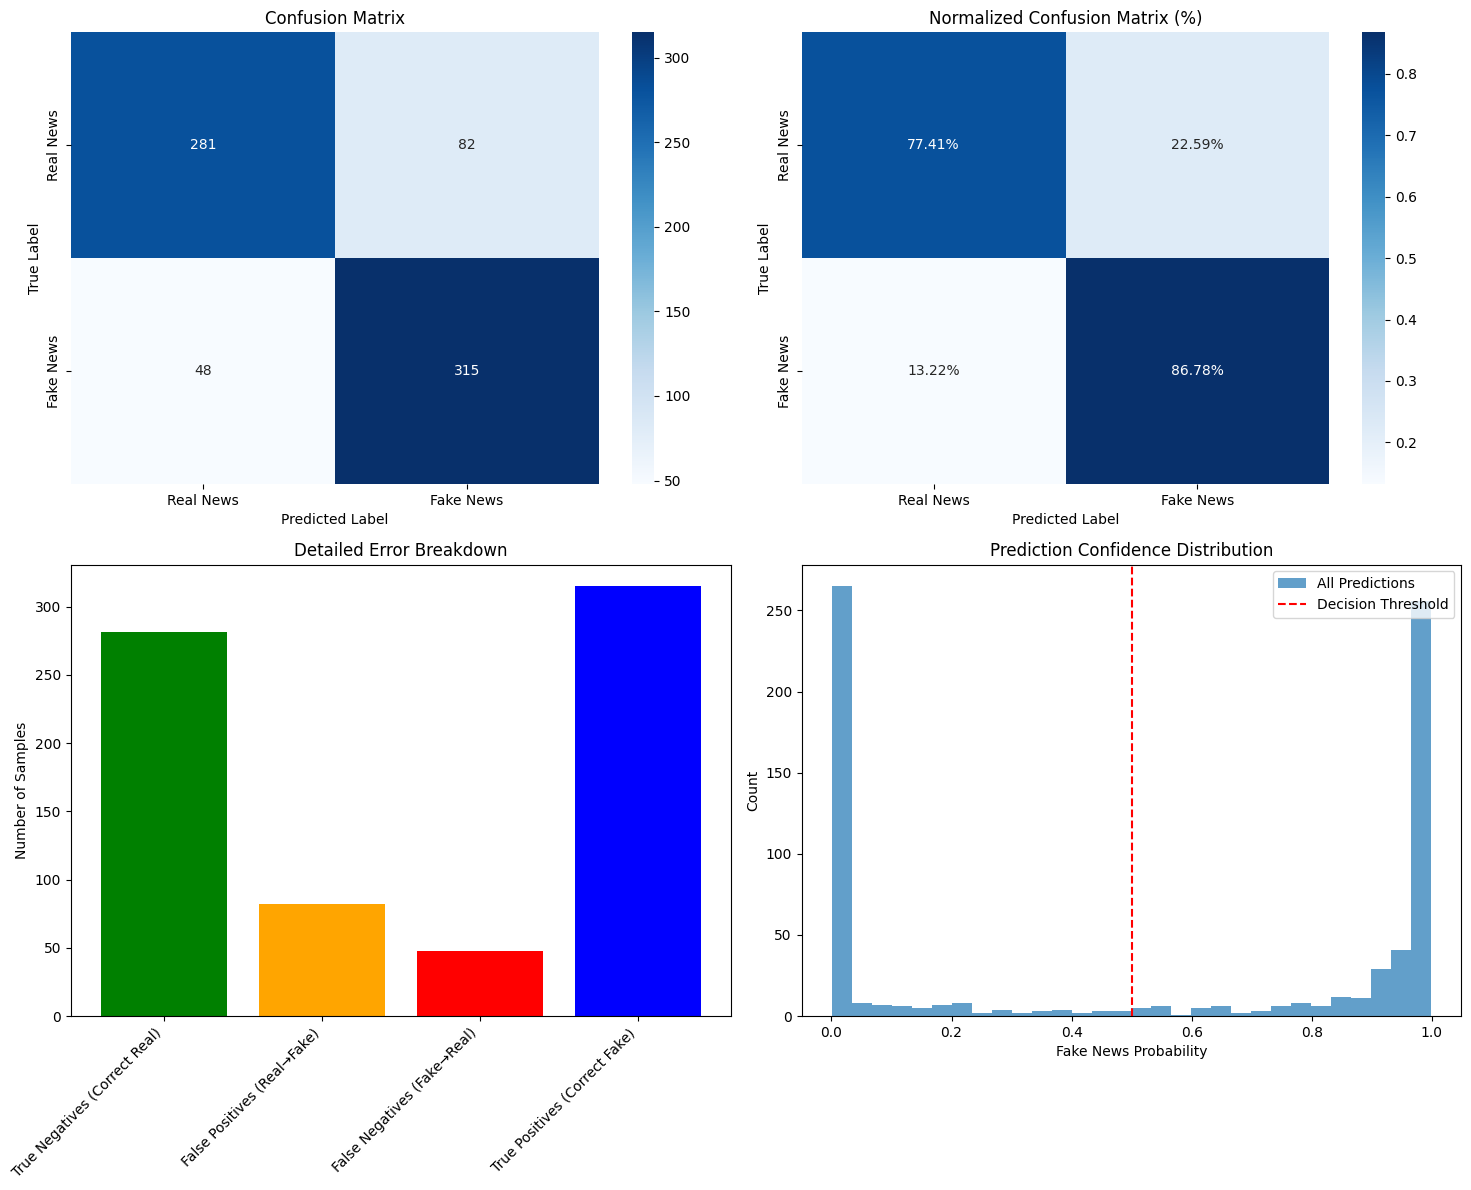

🔍 DETAILED CONFUSION MATRIX ANALYSIS
True Negatives (TN): 281 - Correctly identified Real News
False Positives (FP): 82 - Real News misclassified as Fake
False Negatives (FN): 48 - Fake News misclassified as Real
True Positives (TP): 315 - Correctly identified Fake News

📈 ERROR PATTERN ANALYSIS:
• False Positive Rate among errors: 63.1%
• False Negative Rate among errors: 36.9%
⚠️  Model tends to be more aggressive (flags real news as fake)

🎯 CONFIDENCE ANALYSIS:
• Samples with low confidence (40-60%): 20
• High confidence predictions: 706


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def detailed_confusion_matrix_analysis(y_true, y_pred, y_pred_proba, class_names=['Real News', 'Fake News']):
    """Comprehensive confusion matrix analysis"""
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Basic Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')
    
    # 2. Normalized Confusion Matrix (Percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,1])
    axes[0,1].set_title('Normalized Confusion Matrix (%)')
    axes[0,1].set_xlabel('Predicted Label')
    axes[0,1].set_ylabel('True Label')
    
    # 3. Error Analysis
    tn, fp, fn, tp = cm.ravel()
    
    error_data = {
        'True Negatives (Correct Real)': tn,
        'False Positives (Real→Fake)': fp,
        'False Negatives (Fake→Real)': fn,
        'True Positives (Correct Fake)': tp
    }
    
    colors = ['green', 'orange', 'red', 'blue']
    axes[1,0].bar(error_data.keys(), error_data.values(), color=colors)
    axes[1,0].set_title('Detailed Error Breakdown')
    axes[1,0].set_ylabel('Number of Samples')
    plt.setp(axes[1,0].get_xticklabels(), rotation=45, ha='right')
    
    # 4. Prediction Confidence Distribution
    axes[1,1].hist(y_pred_proba[:, 1], bins=30, alpha=0.7, label='All Predictions')
    axes[1,1].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
    axes[1,1].set_title('Prediction Confidence Distribution')
    axes[1,1].set_xlabel('Fake News Probability')
    axes[1,1].set_ylabel('Count')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Detailed Analysis Report
    print("🔍 DETAILED CONFUSION MATRIX ANALYSIS")
    print("=" * 50)
    print(f"True Negatives (TN): {tn} - Correctly identified Real News")
    print(f"False Positives (FP): {fp} - Real News misclassified as Fake")
    print(f"False Negatives (FN): {fn} - Fake News misclassified as Real")
    print(f"True Positives (TP): {tp} - Correctly identified Fake News")
    print()
    
    # Error Analysis
    print("📈 ERROR PATTERN ANALYSIS:")
    total_errors = fp + fn
    if total_errors > 0:
        fp_rate = fp / total_errors * 100
        fn_rate = fn / total_errors * 100
        print(f"• False Positive Rate among errors: {fp_rate:.1f}%")
        print(f"• False Negative Rate among errors: {fn_rate:.1f}%")
        
        if fp > fn:
            print("⚠️  Model tends to be more aggressive (flags real news as fake)")
        elif fn > fp:
            print("⚠️  Model tends to be more conservative (misses some fake news)")
        else:
            print("✅ Model shows balanced error patterns")
    
    # Confidence Analysis
    low_confidence = np.sum((y_pred_proba[:, 1] > 0.4) & (y_pred_proba[:, 1] < 0.6))
    print(f"\n🎯 CONFIDENCE ANALYSIS:")
    print(f"• Samples with low confidence (40-60%): {low_confidence}")
    print(f"• High confidence predictions: {len(y_pred) - low_confidence}")
    
    return cm, error_data

# Usage with your model
y_pred, y_pred_proba, y_true = get_predictions_and_probabilities(model, test_loader, device)
cm_analysis = detailed_confusion_matrix_analysis(y_true, y_pred, y_pred_proba)
